# Extraction des Chromosomes à partir des Caryotypes

Création de datasets d'entraînement d'un modèle IA

<hr>

In [1]:
import numpy as np
from scipy import ndimage as nd
import os
from skimage import morphology
from skimage.measure import label, regionprops, regionprops_table
from skimage import io, util
import random
from matplotlib import pyplot as plt

## Visualisation des données disponibles

In [2]:
kar1= io.imread("../base_donnees/caryotype/O201551.019.K.TIF")
kar1= util.invert(kar1)
mel1= io.imread("../base_donnees/chr_melanges/O201551.019.A.TIF")
mel1= util.invert(mel1)

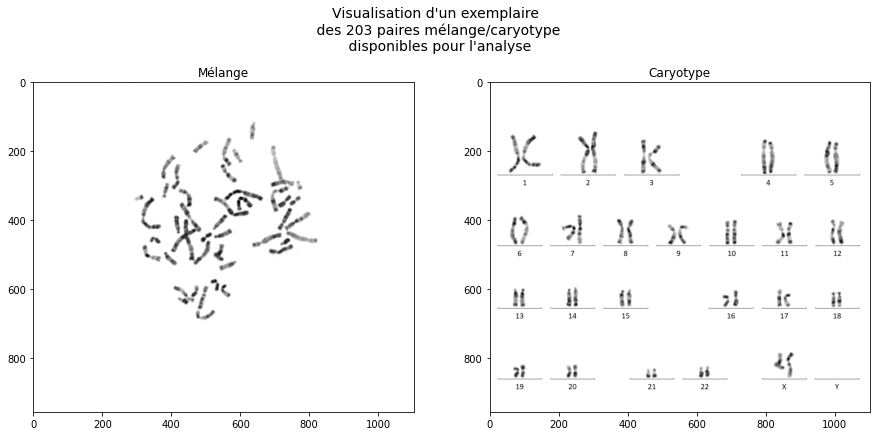

In [4]:
plt.figure(figsize=(15,7))
plt.subplot(121)
plt.imshow(mel1, "gray_r")
plt.title("Mélange")
plt.subplot(122)
plt.imshow(kar1, "gray_r")
plt.title("Caryotype")
plt.suptitle(f'Visualisation d\'un exemplaire \n des { len(os.listdir("../base_donnees/chr_melanges/")) } paires mélange/caryotype \n disponibles pour l\'analyse', fontsize=14)
plt.show()

Les caryotypes ayant tous le même format, on va pouvoir extraire chaque chromosome séparément découpant simplement la matrice, et lui affecter le label correspondant en vue de l'entraînement du modèle de classification. Le mélange ne sera utilisé qu'au moment de la segmentation.

In [5]:
def remove_annot(karyot):
    """cette fonction permet de suuprimer les commentaires et 
    lignes du caryotype pour ne conserver que les chromosomes"""
    kar_modified = karyot.copy()
    kar_modified[266:310,:] = kar_modified[471:515,:] = kar_modified[652:697,:] = kar_modified[857:900,:] = 0.
    return kar_modified


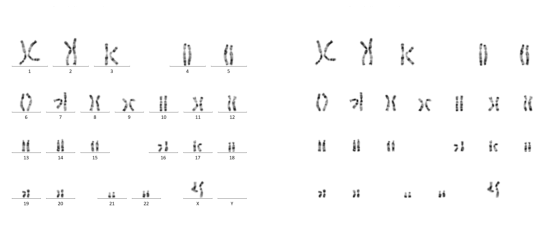

In [10]:
# visualisation du résultat de le première fonction
kar2 = remove_annot(kar1)

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.axis("off")
plt.imshow(kar1, "gray_r")
plt.subplot(132)
plt.axis("off")
plt.imshow(kar2, "gray_r")
plt.show()

In [13]:
def extract_pairs(karyot):
    """extrait des matrices de 128*128 pixels aux emplacements des
    paires de chromosomes (identiques sur tous les caryotypes)"""
    list_of_pairs = [
        karyot[136:280,26:170],
        karyot[136:280,218:362],
        karyot[136:280,386:530],
        karyot[136:280,730:874],
        karyot[136:280,920:1064],
        karyot[336:480,16:160],
        karyot[336:480,176:320],
        karyot[336:480,326:470],
        karyot[336:480,470:614],
        karyot[336:480,626:770],
        karyot[336:480,784:928],
        karyot[336:480,934:1078],
        karyot[518:662,16:160],
        karyot[518:662,176:320],
        karyot[518:662,326:470],
        karyot[518:662,626:770],
        karyot[518:662,784:928],
        karyot[518:662,934:1078],
        karyot[724:868,16:160],
        karyot[724:868,176:320],
        karyot[724:868,396:540],
        karyot[724:868,550:694],
        karyot[724:868,784:928],
        karyot[724:868,934:1078]
    ]
    return list_of_pairs

In [14]:
pairs_kar2_GT = extract_pairs(kar2)

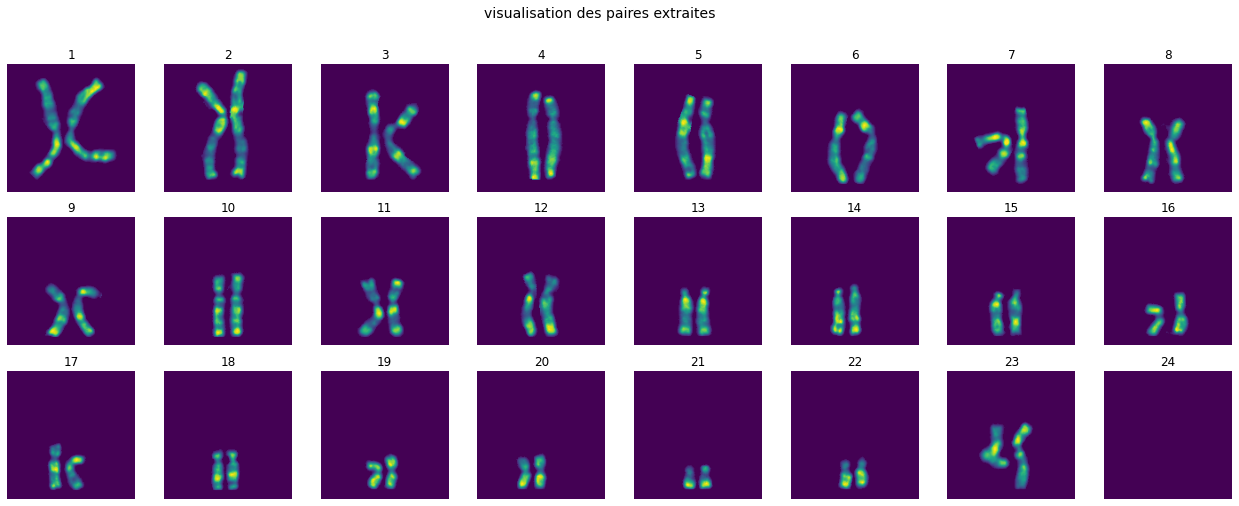

In [23]:
plt.figure(figsize=(22,8))
for i in range(len(pairs_kar2_GT)) :
    plt.subplot(3, 8,i+1)
    plt.imshow(pairs_kar2_GT[i])
    plt.title(i+1)
    plt.axis('off')
    plt.suptitle("visualisation des paires extraites", fontsize=14)
plt.show()

Nous avons séparé les paires, et il est facile d'y associer un label dnas la mesure où elles sont extraites dans l'ordre.
Il faut maintenant récupérer chacun des chromosomes séparément à sur chacune des ces images. 
Allons d'abord créer des masques pour chaque paire extraite, puis nous allons utiliser les modules `morphology` et `measure` de la bibliothèque scikit-image pour segmenter les paires sur les masques, et enfin apliquer ce découpage aux images de chromosomes.


In [20]:
def make_binary_mask(image):
    mask = np.where(image >20, 1, 0)
    arr = mask > 0 # morphology attend un vecteur avec des objets labellisés
    cleaned = morphology.remove_small_objects(arr, 50)
    cleaned = morphology.remove_small_holes(cleaned, 50)
    return cleaned


def separate_pairs(GTpair, MKpair):

    #segmentation
    labels = morphology.label(MKpair, background=0)
    regions = regionprops(labels)

    IWIDTH = 128
    IHEIGHT = 128

    ## extraction
    extracted_chromosomes = []
    extracted_masks =[]

    for region in regions:
        minh, minw, maxh, maxw = region.bbox
        width = maxw-minw
        height = maxh-minh
        grnd = np.copy(GTpair[minh:maxh, minw:maxw])
        mask = np.copy(labels[minh:maxh, minw:maxw])

        insertion_point = ((IWIDTH//2 - width//2), (IHEIGHT//2 - height//2))

        extracted_chrom = np.zeros((IWIDTH,IHEIGHT))
        extracted_mask = np.zeros((IWIDTH,IHEIGHT))

        extracted_mask[insertion_point[1] : insertion_point[1]+height, insertion_point[0] : insertion_point[0]+width] = mask
        extracted_masks.append(extracted_mask)

        extracted_chrom[insertion_point[1] : insertion_point[1]+height, insertion_point[0] : insertion_point[0]+width] = grnd
        extracted_chrom = np.where(extracted_mask>0, extracted_chrom, 0.)
        extracted_chromosomes.append(extracted_chrom)

    extracted_chromosomes = np.asarray(extracted_chromosomes, dtype = np.uint8)

    return extracted_chromosomes, extracted_masks

In [24]:
pairs_kar2_MK= list()
for i in range(len(pairs_kar2_GT)):
    pairs_kar2_MK.append(make_binary_mask(pairs_kar2_GT[i]))

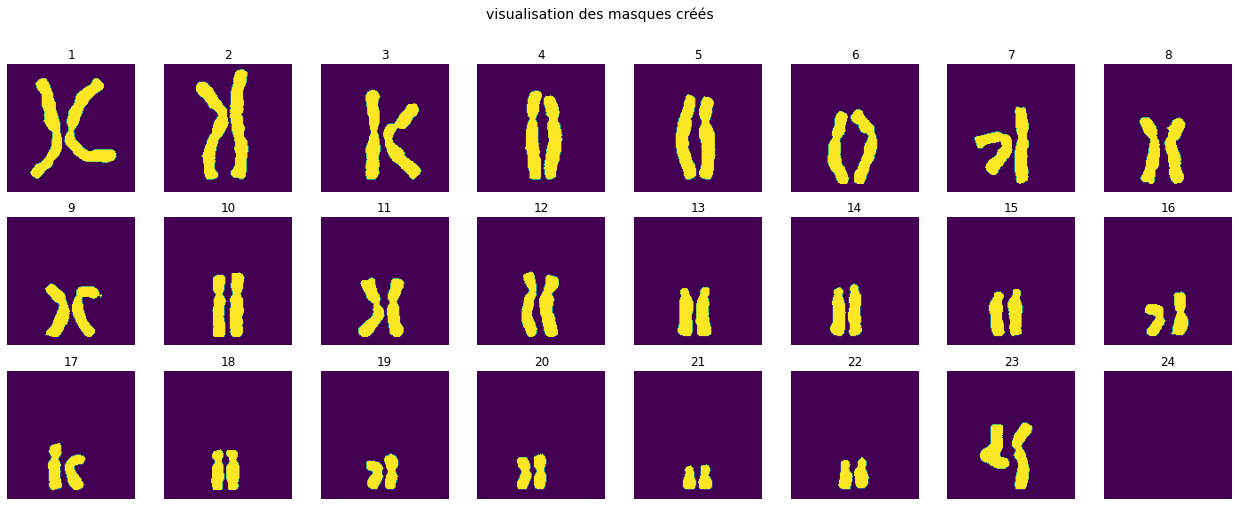

In [25]:
plt.figure(figsize=(22,8))
for i in range(len(pairs_kar2_MK)) :
    plt.subplot(3, 8,i+1)
    plt.imshow(pairs_kar2_MK[i])
    plt.title(i+1)
    plt.axis('off')
    plt.suptitle("visualisation des masques créés", fontsize=14)
plt.show()

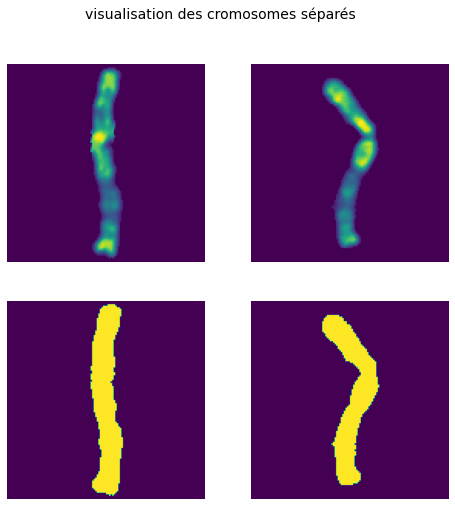

In [29]:
# séparation des paires :
extracted_chromosomes, extracted_masks = separate_pairs(pairs_kar2_GT[1], pairs_kar2_MK[1])

plt.figure(figsize=(8,8))

plt.subplot(221)
plt.imshow(extracted_chromosomes[0])
plt.axis('off')
plt.subplot(222)
plt.imshow(extracted_chromosomes[1])
plt.axis('off')
plt.subplot(223)
plt.imshow(extracted_masks[0])
plt.axis('off')
plt.subplot(224)
plt.imshow(extracted_masks[1])
plt.axis('off')
plt.suptitle("visualisation des cromosomes séparés", fontsize=14)

plt.show()

Nous avons maintenant l'ensemble des fonction nécessaires à la création du dataset. Reste à créer le script pour générer nos données.

In [ ]:
%%script false
for i in range(1, 25):
    os.mkdir(f'../classification_data/{i}')

In [ ]:
"""
Script de création des matrices numpy contenant les chromosomes isolés, 
les labels correspondants, et éventuellement les masques correspondants.
"""

base = "../base_donnees/caryotype/"

X, Y, labels = list(), list(), list()
for i, file in enumerate(os.listdir(base)):
    print(file)
    kar = io.imread(base+file)
    kar = util.invert(kar)
    karGT = remove_annot(kar)
    karMK = make_binary_mask(karGT)

    pairs_GT = extract_pairs(karGT)
    pairs_MK = extract_pairs(karMK)


    try :
        for p in range(24):
            extracted_chromosomes, extracted_masks = separate_pairs(pairs_GT[p], pairs_MK[p])
            for j in range(len(extracted_chromosomes)):
                skimage.io.imsave(                  # sauvegarde des images de chromosomes
                    f"../classification_data/{p+1}/{i}-{j}ch.png", 
                    extracted_chromosomes[j].astype(np.uint8))
                # # dé-commenter pour générer également des images .png à partir des masques :
                # skimage.io.imsave(              
                #     f"../classification_data/{p+1}/{i}-{j}mk.png", 
                #     (extracted_masks[j]*255).astype(np.uint8))
                X.append(extracted_chromosomes[j])
                labels.append(p)
                Y.append(extracted_masks[j])
    except ValueError:
        print("could not process file", file)


X, Y = np.asarray(X), np.asarray(Y)


In [ ]:
# enregistrement des données

with open('../classification_data/X_mono.npy', 'wb') as f:
    np.save(f,X)
with open('../classification_data/labels.npy', 'wb') as f:
    np.save(f,labels)
    # # dé-commenter pour sauvegarder également les masques au format numpy :
with open('../classification_data/Y_mono.npy', 'wb') as f:
    np.save(f,Y)